# Pairs Trading — Copilot Notebook

This notebook reproduces and completes the Medium tutorial "Pairs Trading Strategy using Python" by Andre Nagano (link: https://medium.com/@andrejin.nagano/pair-trading-strategy-using-python-7787adb3d2e2). It implements working code, fills gaps, and provides reproducible backtest examples.

**Repository:** pairs-trading (branch: main)
**File:** test/copilot.ipynb
**Purpose:** runnable, annotated reproduction of the tutorial with fixes and added features.


In [1]:
# Install (uncomment if needed) and import libraries

# Uncomment the next line if packages are missing in your environment
# !{sys.executable} -m pip install pandas numpy matplotlib seaborn statsmodels scikit-learn yfinance scipy

import sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from datetime import datetime
from sklearn.linear_model import LinearRegression
import scipy
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

print('pandas', pd.__version__, 'numpy', np.__version__)
try:
    print('yfinance', yf.__version__)
except Exception:
    pass
try:
    print('statsmodels', sm.__version__)
except Exception:
    pass

# Notebook: Install and import complete

pandas 2.3.3 numpy 2.2.6
yfinance 1.1.0
statsmodels 0.14.6


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ELET3.SA"}}}
$ELET3.SA: possibly delisted; no timezone found

1 Failed download:
['ELET3.SA']: possibly delisted; no timezone found


cointegration p-value: 0.002853022335797815
static beta: 3.377946763072751
metrics: {'total_profit': np.float64(-148.45885984401963), 'max_capital': np.float64(200.41496476825392), 'ann_return': np.float64(-15.22654972759176), 'ann_vol': np.float64(14.367376498437146), 'sharpe': np.float64(-1.0598002863813079)}


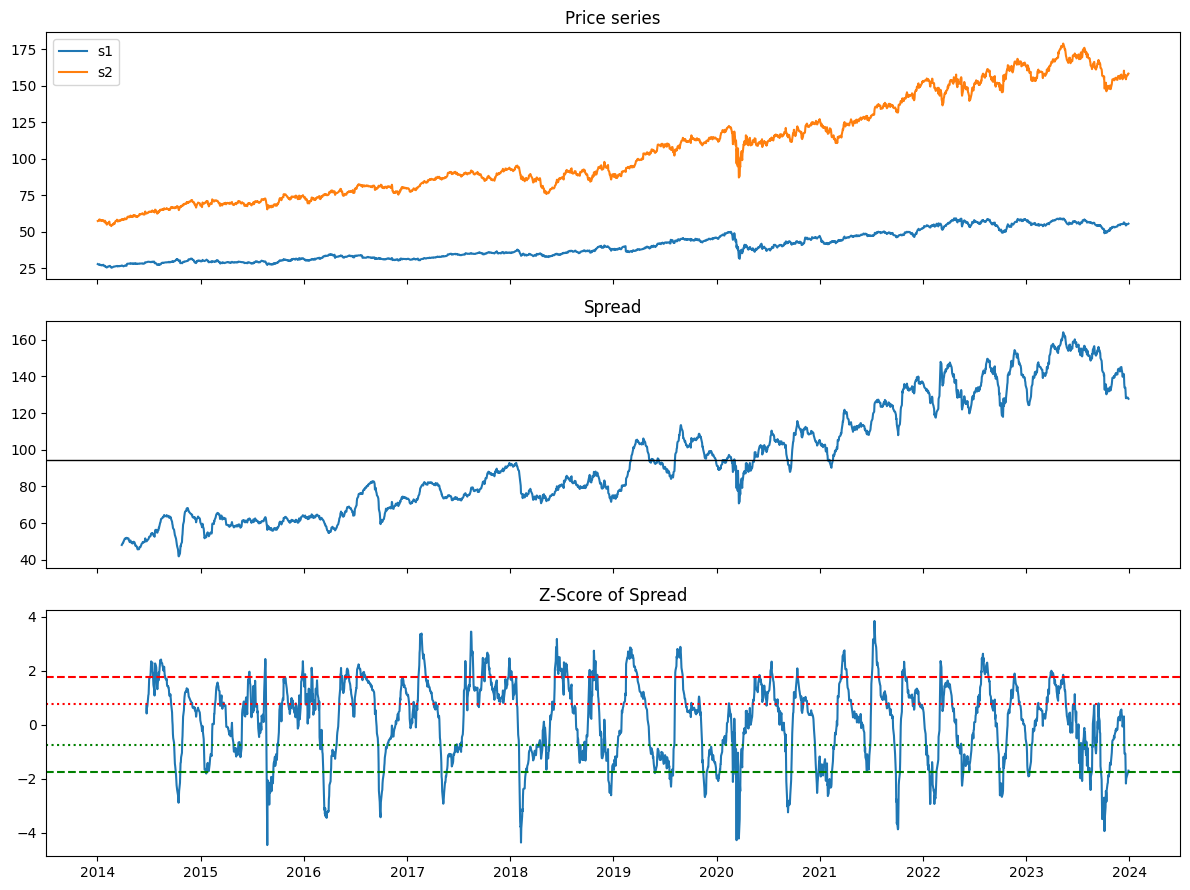

Saved backtest to data/results/pairs_backtest.csv


In [ ]:

# Embedded tutorial excerpt and notes

"""
This section reproduces key explanations from the Medium tutorial (Andre Nagano),
with gaps implemented in code cells below.
- Pairs Trading overview
- Why cointegration matters
- Moving-window beta and z-score method
"""

# Data acquisition and helper functions

def get_historical_data(tickers, start=datetime(2018,1,1), end=datetime.today()):
    """Download adjusted close prices for `tickers` and return DataFrame.
    Uses yfinance download with automatic handling for single/multiple tickers.
    Saves a local CSV snapshot under `data/` for caching.
    """
    out_dir = 'data'
    os.makedirs(out_dir, exist_ok=True)
    key = '_'.join([t.replace('.', '_') for t in tickers])
    fname = os.path.join(out_dir, f'{key}_{start.date()}_{end.date()}.csv')
    try:
        if os.path.exists(fname):
            df = pd.read_csv(fname, index_col=0, parse_dates=True)
            return df
    except Exception:
        pass
    # yfinance can accept list of tickers
    data = yf.download(tickers, start=start, end=end, progress=False, threads=True)
    if isinstance(data, pd.DataFrame) and 'Adj Close' in data.columns:
        df = data['Adj Close'].copy()
    else:
        # If single ticker, data might be a Series
        df = data['Adj Close'] if 'Adj Close' in data else data
    # Ensure dataframe and proper column names
    if isinstance(df, pd.Series):
        df = df.to_frame(name=tickers[0])
    df.dropna(how='all', inplace=True)
    df.to_csv(fname)
    return df

import os

# Cointegration test wrapper

def coint_test(s1, s2):
    """Return (t_stat, pvalue, crit_values)
    """
    try:
        res = ts.coint(s1, s2)
        return res[0], res[1], res[2]
    except Exception as e:
        return None, None, None

# OLS hedge ratio

def estimate_beta_ols(y, x, add_const=True):
    X = sm.add_constant(x) if add_const else x
    mdl = sm.OLS(y, X, missing='drop').fit()
    if add_const:
        intercept = mdl.params['const'] if 'const' in mdl.params.index else mdl.params.iloc[0]
        beta = mdl.params.drop('const').iloc[0] if 'const' in mdl.params.index else mdl.params.iloc[0]
        return beta, intercept, mdl
    else:
        return mdl.params.iloc[0], 0, mdl

# Spread and moving beta

def moving_beta_and_spread(s1, s2, window=60):
    # following tutorial: moving_cov = s1.rolling(window).cov(s2), moving_var = s2.rolling(window).var()
    moving_cov = s1.rolling(window).cov(s2)
    moving_var = s2.rolling(window).var()
    moving_beta = moving_cov / moving_var
    spread = s2 - moving_beta * s1
    return moving_beta, spread

# Moving z-score for spread

def moving_zscore(spread, window1=1, window2=60):
    ma1 = spread.rolling(window1).mean()
    ma2 = spread.rolling(window2).mean()
    std2 = spread.rolling(window2).std()
    z = (ma1 - ma2) / std2
    return z

# Signal generation

def generate_signals(zscore, entry=1.75, exit=0.75):
    """Return long/short signals for spread zscore series.
    - long spread when z < -entry (buy spread = buy y, short beta*x)
    - short spread when z > entry (sell spread)
    Close when abs(z) < exit
    Signals: 1 for long spread, -1 for short spread, 0 otherwise
    """
    sig = pd.Series(0, index=zscore.index)
    sig[zscore < -entry] = 1
    sig[zscore > entry] = -1
    # propagate position until exit
    pos = sig.copy()
    current = 0
    for i in range(len(sig)):
        if sig.iloc[i] != 0:
            current = sig.iloc[i]
        else:
            if abs(zscore.iloc[i]) < exit:
                current = 0
        pos.iloc[i] = current
    return pos

# Simple backtest: position is units of spread exposure: 1 unit means long 1 of y and short beta of x

def backtest_pairs(s1, s2, beta_series, positions, transaction_cost=0.0):
    """positions: series with values 1 (long spread), -1 (short spread), 0
    beta_series: series of beta (e.g. moving_beta) aligned to prices
    Returns DataFrame with daily pnl and performance metrics.
    """
    # Ensure alignment
    df = pd.DataFrame({'s1': s1, 's2': s2, 'beta': beta_series, 'pos': positions}).dropna()
    # Calculate daily returns (price differences) for PnL calculation using price changes
    df['s1_ret'] = df['s1'].diff()
    df['s2_ret'] = df['s2'].diff()
    # Position: when pos==1 (long spread) => long s2 (1 unit), short s1 (beta units)
    df['pnl'] = 0.0
    df['capital_deployed'] = 0.0
    current_pos = 0
    # Vectorized pnl approximation: pnl_t = pos_t * (s2_ret_t - beta_t * s1_ret_t)
    df['pnl'] = df['pos'] * (df['s2_ret'] - df['beta'] * df['s1_ret'])
    # transaction cost when position changes
    df['pos_change'] = df['pos'].diff().abs()
    df['tx_cost'] = df['pos_change'] * transaction_cost
    df['pnl_after_cost'] = df['pnl'] - df['tx_cost']
    df['cum_pnl'] = df['pnl_after_cost'].cumsum()
    # daily returns normalized by capital deployed approximation (abs market value)
    df['capital_deployed'] = (df['pos'].abs() * (df['s2'].abs() + df['beta'].abs() * df['s1'].abs()))
    max_capital = df['capital_deployed'].max()
    total_profit = df['cum_pnl'].iloc[-1]
    # annualized metrics using daily data
    daily_ret = df['pnl_after_cost'].fillna(0)
    ann_return = daily_ret.mean() * 252
    ann_vol = daily_ret.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    metrics = {
        'total_profit': total_profit,
        'max_capital': max_capital,
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe
    }
    return df, metrics

# Visualization helper

def plot_prices_and_spread(s1, s2, spread, zscore=None, entry=1.75, exit=0.75, buy_idx=None, sell_idx=None):
    fig, axes = plt.subplots(3 if zscore is not None else 2, 1, figsize=(12, 9), sharex=True)
    axes = axes.flatten()
    axes[0].plot(s1, label='s1')
    axes[0].plot(s2, label='s2')
    axes[0].legend()
    axes[0].set_title('Price series')
    axes[1].plot(spread, label='spread')
    axes[1].axhline(spread.mean(), color='k', lw=1)
    axes[1].set_title('Spread')
    if zscore is not None:
        axes[2].plot(zscore, label='zscore')
        axes[2].axhline(entry, color='red', linestyle='--')
        axes[2].axhline(-entry, color='green', linestyle='--')
        axes[2].axhline(exit, color='red', linestyle=':')
        axes[2].axhline(-exit, color='green', linestyle=':')
        axes[2].set_title('Z-Score of Spread')
    plt.tight_layout()
    plt.show()

# Example run cell: try tutorial pair, fallback to US pair

try:
    tickers = ['TAEE11.SA', 'ELET3.SA']
    df_prices = get_historical_data(tickers, start=datetime(2018,1,1), end=datetime(2023,12,31))
    if df_prices.isnull().all().all() or df_prices.shape[1] < 2:
        raise Exception('Insufficient Brazil data, fallback')
except Exception:
    tickers = ['KO', 'PEP']
    df_prices = get_historical_data(tickers, start=datetime(2014,1,1), end=datetime(2023,12,31))

s1 = df_prices.iloc[:,0]
s2 = df_prices.iloc[:,1]

# Quick cointegration check
t_stat, pval, crit = coint_test(s1.dropna(), s2.dropna())
print('cointegration p-value:', pval)

# Estimate static beta
beta_static, intercept, mdl = estimate_beta_ols(s2.dropna(), s1.dropna())
print('static beta:', beta_static)

# moving beta and spread
moving_beta, spread = moving_beta_and_spread(s1, s2, window=60)
z = moving_zscore(spread, window1=1, window2=60)

# signals and backtest
pos = generate_signals(z, entry=1.75, exit=0.75)
df_bt, metrics = backtest_pairs(s1, s2, moving_beta, pos, transaction_cost=0.0)
print('metrics:', metrics)

# plots
plot_prices_and_spread(s1, s2, spread, zscore=z)

# Save results
os.makedirs('data/results', exist_ok=True)
df_bt.to_csv('data/results/pairs_backtest.csv')

print('Saved backtest to data/results/pairs_backtest.csv')
